In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import os 

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

from src.utils.time_series_procs import split_sequences

In [2]:
def plot_time_series_train_and_prediction_windows(df, model, cut_date):
    index = df['Data/Hora'].shape[0] - df[df['Data/Hora'] == cut_date].index[0] 
    index = -index
    y = df['R28D'].values
    d = df['Data/Hora'].values
    test_series = pd.DataFrame({'ccs28':y}, index=pd.to_datetime(d))
    pred_series = model.predict(x_test)
    diff = pred_series.shape[0] + index
    pred_series = pd.DataFrame({'ccs28-pred' : pred_series.squeeze()}, index=pd.to_datetime(d[index-diff:]))

    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15, 7))

    test_series.plot(ax=ax)
    ax.axvline(test_series.index[index], color='r') # end of train dataset
    pred_series[index:].plot(ax=ax)
    ax.grid(which="both")
    ax.legend(["train and test series", "end of train series", 'predicted'], loc="upper left")
    ax.set_ylabel('Compressive Strength - MPa', labelpad=20, fontsize=15)
    plt.show()

In [3]:
def get_times_series_data(df, cut_date):
    columns = list(df.columns.drop(['R28D']))
    columns.append('R28D')
    df = df.reindex(columns=columns)
    df['Data/Hora'] = pd.to_datetime(df['Data/Hora'])
    df_train = df[df['Data/Hora'] < cut_date]
    df_test = df[df['Data/Hora'] >= cut_date]
    df_train = df_train.drop(['Data/Hora'], axis=1)
    df_test = df_test.drop(['Data/Hora'], axis=1)
    x_train, y_train = split_sequences(df_train.values, TIME_STEPS)
    x_test, y_test = split_sequences(df_test.values, TIME_STEPS)
    return x_train, y_train, x_test, y_test

In [4]:
class StandardScaler3DShape():
    def __init__(self):
        self.scaler = StandardScaler()
    def fit_transform(self,X, y=None):
        X_new = self.scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
        return X_new
        
    def fit(self,X, y=None):
        X_new = X.reshape(-1, X.shape[-1])
        self.scaler.fit(X_new)
        return self
    
    def transform(self,X,y=None):
        X_new = self.scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
        return X_new

<h3>Force tensorflow use CPU only</h3>

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

<h3>Disable Tensorflow Warnings</h3>

In [6]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [7]:
name = "dados-historicos-partner_i-cement-CPIIF40.csv"
df_r3d_and_r7d = pd.read_csv("../../data/interim/" + "r3d-and-r7d-" + name)
df_r3d_only = pd.read_csv("../../data/interim/" + "r3d-only-" + name)
df_no_r3d_r7d = pd.read_csv("../../data/interim/" + "no-r3d-r7d-" + name)

In [8]:
seed = 47
scaler = StandardScaler()

In [9]:
cut_date = '2021-05-02'
TIME_STEPS = 3

# Neural Network Long Short Term Memory - LSTM

# Baseline models

First we will train a baseline model and verify its overall performance on each of the three datasets.

# Configs:

1. Train Period: [01-01-2019, 2021-05-02)

2. Test Period:  (2021-05-02, 2021-11-31]

3. TIMESTEPS: [1, 3, 5, 7, 10, 15]

4. Epochs: 100

5. Batch size: 32

6. LSTM Cells: 64

7. LSTM Layers: 1

8. Optimization Algorithm: Adam
    
    8.1. Learning Rate: 1e-2

In [10]:
def get_baseline_model(n_units=64):
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.LSTM(units=n_units))
    model.add(tf.keras.layers.Dense(1))

    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")])
    return model

<h3> Baseline model - Dataset: df_no_r3d_r7d</h3>

In [11]:
df = df_no_r3d_r7d.copy()
x_train, y_train, x_test, y_test = get_times_series_data(df, cut_date)
x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

In [12]:
model = get_baseline_model()
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
rmse = model.evaluate(x_test, y_test, verbose=0)
print('RMSE: %.3f' % rmse[1])

RMSE: 2.603


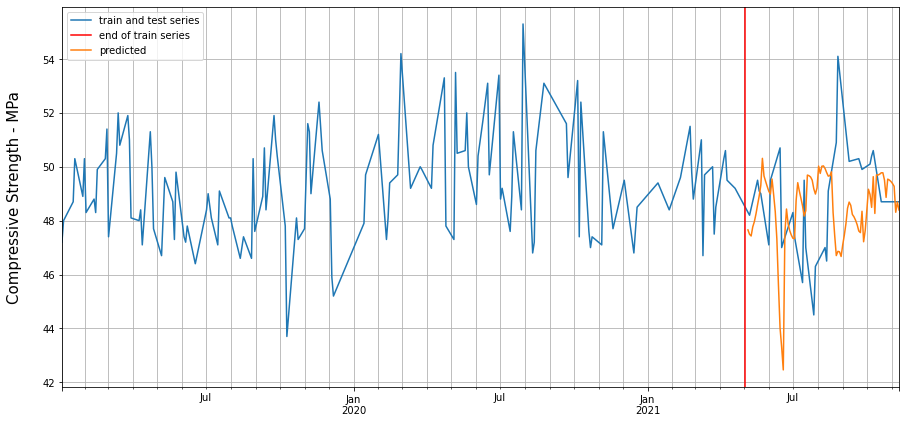

In [13]:
plot_time_series_train_and_prediction_windows(df, model, cut_date)

<h3> Baseline model - Dataset: df_r3d_only</h3>

In [14]:
df = df_r3d_only.copy()
x_train, y_train, x_test, y_test = get_times_series_data(df, cut_date)
x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

In [15]:
model = get_baseline_model()
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
rmse = model.evaluate(x_test, y_test, verbose=0)
print('RMSE: %.3f' % rmse[1])

RMSE: 1.984


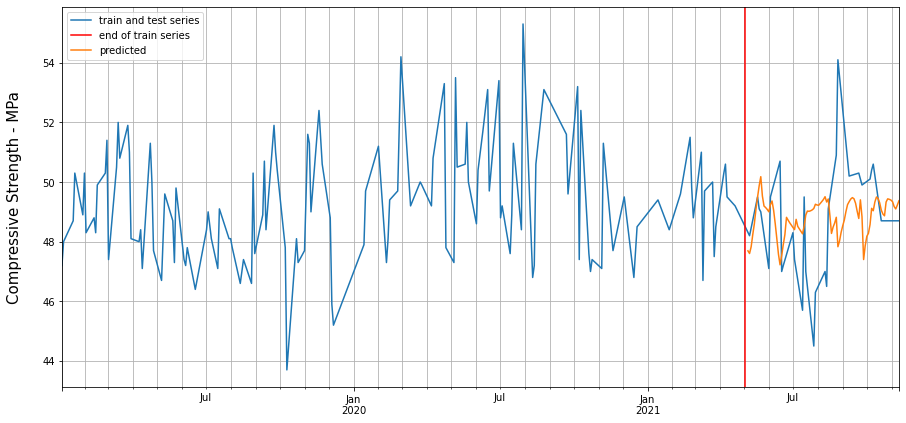

In [16]:
plot_time_series_train_and_prediction_windows(df, model, cut_date)

<h3> Baseline model - Dataset: df_r3d_and_r7d</h3>

In [17]:
df = df_r3d_and_r7d.copy()
x_train, y_train, x_test, y_test = get_times_series_data(df, cut_date)
x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

In [18]:
model = get_baseline_model()
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
rmse = model.evaluate(x_test, y_test, verbose=0)
print('RMSE: %.3f' % rmse[1])

RMSE: 2.108


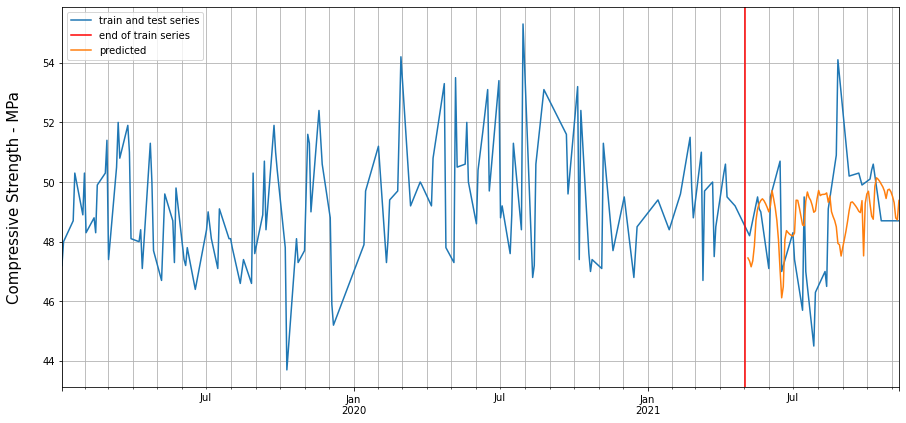

In [19]:
plot_time_series_train_and_prediction_windows(df, model, cut_date)

# Grid Search CV

Before doing Repeated Cross Validation, we shall search for the best parameters. To do so, Keras Tuner will be used
to accomplish the Grid Search.

<h3>GridCV - Scikit Learn</h3>

In [20]:
def create_keras_model(activation='tanh', dropout_rate=0.0, n_units=64, n_layers=1, learning_rate=1e-3):
    model = tf.keras.Sequential()
    
    for i in range(n_layers):
        if i + 1 < n_layers:
            model.add(tf.keras.layers.LSTM(units=n_units, activation=activation, return_sequences=True))
        else:
            model.add(tf.keras.layers.LSTM(units=n_units, activation=activation, return_sequences=False))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="mse",
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")])
    return model

In [21]:
def make_grid_search(x, y):
    activation = ['tanh', 'relu', 'swish']
    dropout_rate = [0.0, 0.1]
    n_units = [32, 64]
    n_layers = [1, 2, 3]
    learning_rate = [0.001, 0.01, 0.1]
    epochs = [100]
    batches = [32]

    param_grid = dict(model__activation=activation,
                      model__dropout_rate=dropout_rate, 
                      model__n_units=n_units,
                      model__n_layers=n_layers, 
                      model__learning_rate=learning_rate,
                      model__epochs=epochs,
                      model__batch_size=batches)

    model = KerasRegressor(build_fn=create_keras_model, epochs=30, batch_size=32, verbose=0)
    pipeline = Pipeline(steps=[('transformer', StandardScaler3DShape()), ('model', model)])

    grid = GridSearchCV(estimator=pipeline, 
                        param_grid=param_grid,
                        n_jobs=-1,
                        cv=3, 
                        scoring='neg_root_mean_squared_error')
    
    grid_result = grid.fit(x, y)

    print("Best: %f using %s\n" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    return grid

<h3>GridCV 1</h3>

<b>Dataset: df_no_r3d_r7d:</b> In this dataset the R3D and R7D variables are not considered.

In [22]:
df = df_no_r3d_r7d.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)
x, y = split_sequences(df.values, TIME_STEPS)

start = time.time()
gridcv1 = make_grid_search(x, y)
end = time.time()
print("\nMinutes Elapsed: ", (end - start)/60)

/tmp/ipykernel_999193/3700414713.py:18: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasRegressor(build_fn=create_keras_model, epochs=30, batch_size=32, verbose=0)


Best: -1.869974 using {'model__activation': 'tanh', 'model__batch_size': 32, 'model__dropout_rate': 0.1, 'model__epochs': 100, 'model__learning_rate': 0.01, 'model__n_layers': 3, 'model__n_units': 64}

-10.701436 (1.743492) with: {'model__activation': 'tanh', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__n_layers': 1, 'model__n_units': 32}
-3.795249 (3.078685) with: {'model__activation': 'tanh', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__n_layers': 1, 'model__n_units': 64}
-11.298910 (0.665066) with: {'model__activation': 'tanh', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__n_layers': 2, 'model__n_units': 32}
-2.270158 (0.959623) with: {'model__activation': 'tanh', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__n_la

In [23]:
gridcv1.best_params_

{'model__activation': 'tanh',
 'model__batch_size': 32,
 'model__dropout_rate': 0.1,
 'model__epochs': 100,
 'model__learning_rate': 0.01,
 'model__n_layers': 3,
 'model__n_units': 64}

<h3>GridCV 2</h3>

<b>Dataset: df_r3d_only:</b> In this dataset only R3D is considered.

In [24]:
df = df_r3d_only.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)
x, y = split_sequences(df.values, TIME_STEPS)

start = time.time()
gridcv2 = make_grid_search(x, y)
end = time.time()
print("\nMinutes Elapsed: ", (end - start)/60)

/tmp/ipykernel_999193/3700414713.py:18: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasRegressor(build_fn=create_keras_model, epochs=30, batch_size=32, verbose=0)


Best: -1.903164 using {'model__activation': 'tanh', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.01, 'model__n_layers': 3, 'model__n_units': 64}

-10.220187 (0.962951) with: {'model__activation': 'tanh', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__n_layers': 1, 'model__n_units': 32}
-3.148072 (2.251606) with: {'model__activation': 'tanh', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__n_layers': 1, 'model__n_units': 64}
-11.384575 (1.096466) with: {'model__activation': 'tanh', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__n_layers': 2, 'model__n_units': 32}
-2.029602 (0.648955) with: {'model__activation': 'tanh', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__n_la

In [25]:
gridcv2.best_params_

{'model__activation': 'tanh',
 'model__batch_size': 32,
 'model__dropout_rate': 0.0,
 'model__epochs': 100,
 'model__learning_rate': 0.01,
 'model__n_layers': 3,
 'model__n_units': 64}

<h3>GridCV 3</h3>

<b>Dataset: df_r3d_and_r7d:</b> In this dataset R3D and R7D are considered.

In [26]:
df = df_r3d_and_r7d.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)
x, y = split_sequences(df.values, TIME_STEPS)

start = time.time()
gridcv3 = make_grid_search(x, y)
end = time.time()
print("\nMinutes Elapsed: ", (end - start)/60)

/tmp/ipykernel_999193/3700414713.py:18: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasRegressor(build_fn=create_keras_model, epochs=30, batch_size=32, verbose=0)


Best: -1.897832 using {'model__activation': 'tanh', 'model__batch_size': 32, 'model__dropout_rate': 0.1, 'model__epochs': 100, 'model__learning_rate': 0.01, 'model__n_layers': 3, 'model__n_units': 32}

-10.338316 (0.836199) with: {'model__activation': 'tanh', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__n_layers': 1, 'model__n_units': 32}
-2.448132 (1.211729) with: {'model__activation': 'tanh', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__n_layers': 1, 'model__n_units': 64}
-11.558873 (1.107827) with: {'model__activation': 'tanh', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__n_layers': 2, 'model__n_units': 32}
-2.113386 (0.700604) with: {'model__activation': 'tanh', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__n_la

In [27]:
gridcv3.best_params_

{'model__activation': 'tanh',
 'model__batch_size': 32,
 'model__dropout_rate': 0.1,
 'model__epochs': 100,
 'model__learning_rate': 0.01,
 'model__n_layers': 3,
 'model__n_units': 32}

<h2>Times Series KFold Cross validation</h2>

Here we will make a Times Series KFold Cross validation with all 3 datasets. Here we are using the <b>Blocking           Time Series Split</b> method. And with timeseries Split method

In [28]:
def make_repeated_time_series_k_fold(x, 
                                     y, 
                                     train_period, 
                                     test_period,
                                     grid=None,
                                     repeats=10,
                                     show_individual_results=True,
                                     show_final_result=True,
                                     params=None):
    results = []
    max_samples = x.shape[0]
    
    if grid:
        activation = grid.best_params_['model__activation']
        dropout_rate = grid.best_params_['model__dropout_rate']
        n_units = grid.best_params_['model__n_units']
        n_layers = grid.best_params_['model__n_layers']
        learning_rate = grid.best_params_['model__learning_rate']
        batch_size = grid.best_params_['model__batch_size']
        epochs = grid.best_params_['model__epochs']
    else:
        activation = params['activation']
        dropout_rate = params['dropout_rate']
        n_units = params['n_units']
        n_layers = params['n_layers']
        learning_rate = params['learning_rate']
        batch_size = params['batch_size']
        epochs = params['epochs']
    
    for _ in range(repeats):
        i = 0
        scores = []
        for _ in range(0, max_samples//train_period):
            x_train = x[i:i+train_period]
            y_train = y[i:i+train_period]
            x_test = x[i+train_period: i+train_period+test_period]
            y_test = y[i+train_period: i+train_period+test_period]
            i += train_period
            x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
            x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)
            model = create_keras_model(activation=activation,
                                       dropout_rate=dropout_rate,
                                       n_units=n_units,
                                       n_layers=n_layers,
                                       learning_rate=learning_rate)
            model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
            rmse = model.evaluate(x_test, y_test, verbose=0)
            scores.append(rmse[1])
        results.append(scores)
        if show_individual_results:
            print('RMSE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
    if show_final_result:
        print('\nRMSE: %.3f (%.3f)' % (np.mean(results), np.std(results)))
    return results

<h3> Time Series Repeated KFold Cross Validation - df_no_r3d_r7d</h3>

<b>Dataset: df_no_r3d_r7d:</b> In this dataset the R3D and R7D variables are not considered.

In [29]:
df = df_no_r3d_r7d.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)
x, y = split_sequences(df.values, TIME_STEPS)

<h4>Experiment 1</h4>
    
<b>Train 6 months and predicts one month every year</b>

In [30]:
train_period = 90 # 6 months of data since the data is spaced every 2 days
test_period = 15 # 1 month
repeats = 10
results = make_repeated_time_series_k_fold(x, y, train_period, test_period, gridcv1, repeats)

RMSE: 1.431 (0.600)
RMSE: 1.458 (0.570)
RMSE: 1.431 (0.567)
RMSE: 1.479 (0.569)
RMSE: 1.393 (0.585)
RMSE: 1.482 (0.593)
RMSE: 1.443 (0.624)
RMSE: 1.424 (0.557)
RMSE: 1.444 (0.592)
RMSE: 1.461 (0.598)

RMSE: 1.445 (0.586)


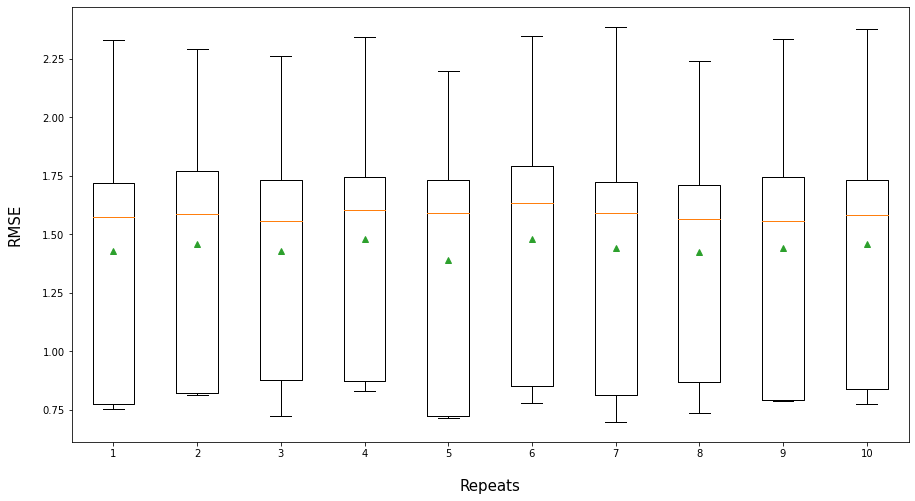

In [31]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 2</h4>
    
<b>Train 11 months and predicts one month every year</b>

In [32]:
train_period = 165 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 15 # 1 month
repeats = 10
results = make_repeated_time_series_k_fold(x, y, train_period, test_period, gridcv1, repeats)

RMSE: 1.887 (0.578)
RMSE: 1.863 (0.603)
RMSE: 1.759 (0.577)
RMSE: 1.851 (0.641)
RMSE: 1.894 (0.543)
RMSE: 1.897 (0.604)
RMSE: 1.820 (0.426)
RMSE: 1.836 (0.620)
RMSE: 1.836 (0.700)
RMSE: 1.797 (0.534)

RMSE: 1.844 (0.588)


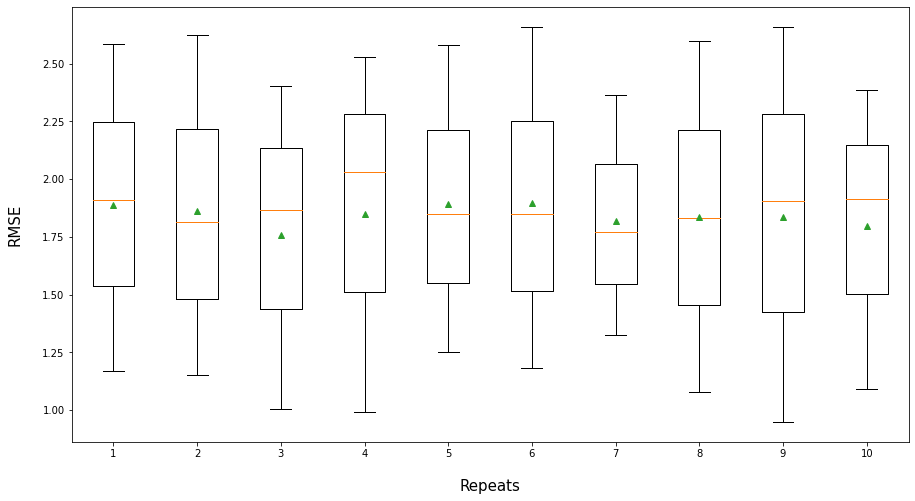

In [33]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 3</h4>
    
<b>Train 2 years and 10 months and predicts october and november of 2021</b>

In [34]:
train_period = 495 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 30 # 2 months
repeats = 10
results = make_repeated_time_series_k_fold(x, y, train_period, test_period, gridcv1, repeats)

RMSE: 0.756 (0.000)
RMSE: 0.868 (0.000)
RMSE: 0.744 (0.000)
RMSE: 0.734 (0.000)
RMSE: 0.649 (0.000)
RMSE: 0.790 (0.000)
RMSE: 0.802 (0.000)
RMSE: 0.724 (0.000)
RMSE: 0.745 (0.000)
RMSE: 1.099 (0.000)

RMSE: 0.791 (0.116)


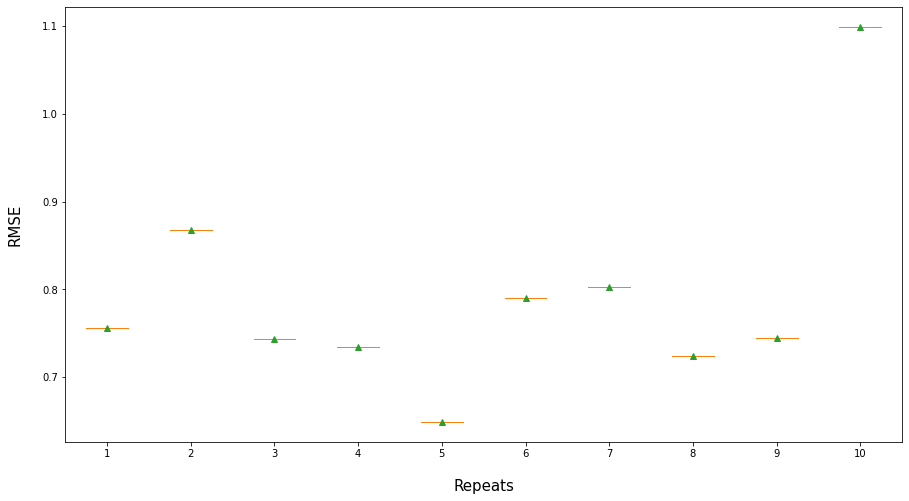

In [35]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h3> Time Series Repeated KFold Cross Validation - df_r3d_only</h3>

<b>Dataset: df_r3d_only:</b> In this dataset only R3D variable is considered.

In [36]:
df = df_r3d_only.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)
x, y = split_sequences(df.values, TIME_STEPS)

<h4>Experiment 1</h4>
    
<b>Train 6 months and predicts one month every year</b>

In [37]:
train_period = 90 # 6 months of data since the data is spaced every 2 days
test_period = 15 # 1 month
repeats = 10
results = make_repeated_time_series_k_fold(x, y, train_period, test_period, gridcv2, repeats)

RMSE: 1.487 (0.578)
RMSE: 1.482 (0.579)
RMSE: 1.486 (0.571)
RMSE: 1.479 (0.584)
RMSE: 1.489 (0.572)
RMSE: 1.485 (0.578)
RMSE: 1.485 (0.575)
RMSE: 1.482 (0.577)
RMSE: 1.486 (0.576)
RMSE: 1.482 (0.578)

RMSE: 1.484 (0.577)


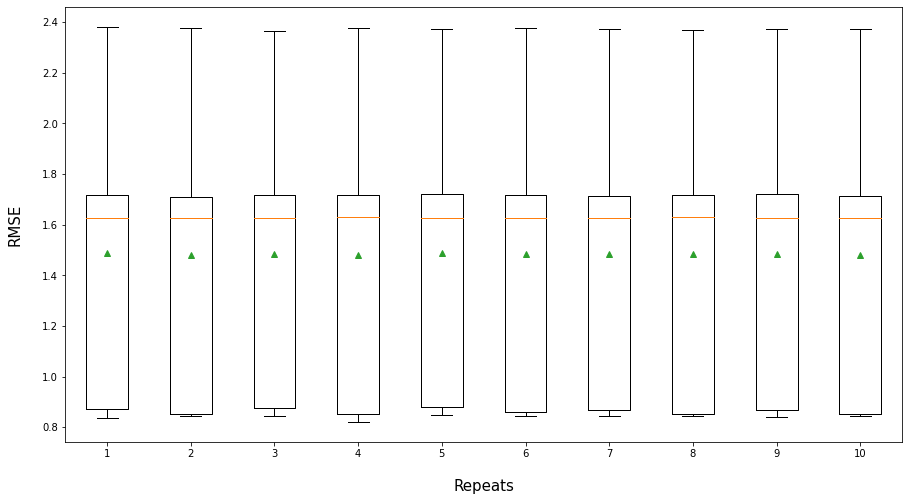

In [38]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 2</h4>
    
<b>Train 11 months and predicts one month every year</b>

In [39]:
train_period = 165 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 15 # 1 month
repeats = 10
results = results = make_repeated_time_series_k_fold(x, y, train_period, test_period, gridcv2, repeats)

RMSE: 1.869 (0.656)
RMSE: 1.919 (0.581)
RMSE: 1.857 (0.557)
RMSE: 1.826 (0.632)
RMSE: 1.942 (0.641)
RMSE: 1.886 (0.580)
RMSE: 1.900 (0.675)
RMSE: 1.889 (0.635)
RMSE: 1.905 (0.627)
RMSE: 1.955 (0.685)

RMSE: 1.895 (0.629)


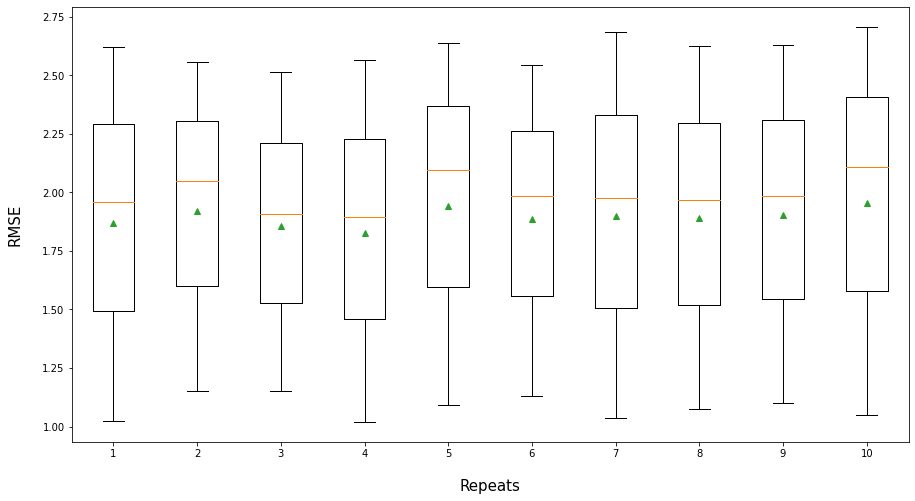

In [40]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 3</h4>
    
<b>Train 2 years and 10 months and predicts october and november of 2021</b>

In [41]:
train_period = 495 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 30 # 2 months
repeats = 10
results = results = make_repeated_time_series_k_fold(x, y, train_period, test_period, gridcv2, repeats)

RMSE: 1.278 (0.000)
RMSE: 0.761 (0.000)
RMSE: 1.168 (0.000)
RMSE: 1.103 (0.000)
RMSE: 1.215 (0.000)
RMSE: 1.154 (0.000)
RMSE: 0.700 (0.000)
RMSE: 1.008 (0.000)
RMSE: 1.043 (0.000)
RMSE: 0.748 (0.000)

RMSE: 1.018 (0.199)


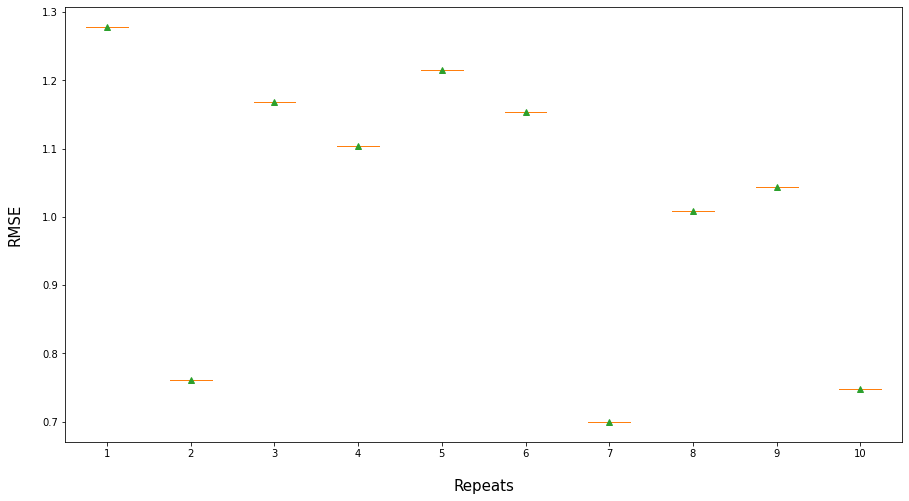

In [42]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h3> Time Series Repeated KFold Cross Validation - df_r3d_and_r7d</h3>

<b>Dataset: df_r3d_and_r7d:</b> In this dataset both R3D and R7D variables are considered.

In [43]:
df = df_r3d_and_r7d.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)
x, y = split_sequences(df.values, TIME_STEPS)

<h4>Experiment 1</h4>
    
<b>Train 6 months and predicts one month every year</b>

In [44]:
train_period = 90 # 6 months of data since the data is spaced every 2 days
test_period = 15 # 1 month
repeats = 10
results = results = make_repeated_time_series_k_fold(x, y, train_period, test_period, gridcv3, repeats)

RMSE: 1.316 (0.643)
RMSE: 1.319 (0.635)
RMSE: 1.320 (0.641)
RMSE: 1.343 (0.626)
RMSE: 1.323 (0.652)
RMSE: 1.301 (0.624)
RMSE: 1.322 (0.621)
RMSE: 1.292 (0.644)
RMSE: 1.327 (0.649)
RMSE: 1.337 (0.651)

RMSE: 1.320 (0.639)


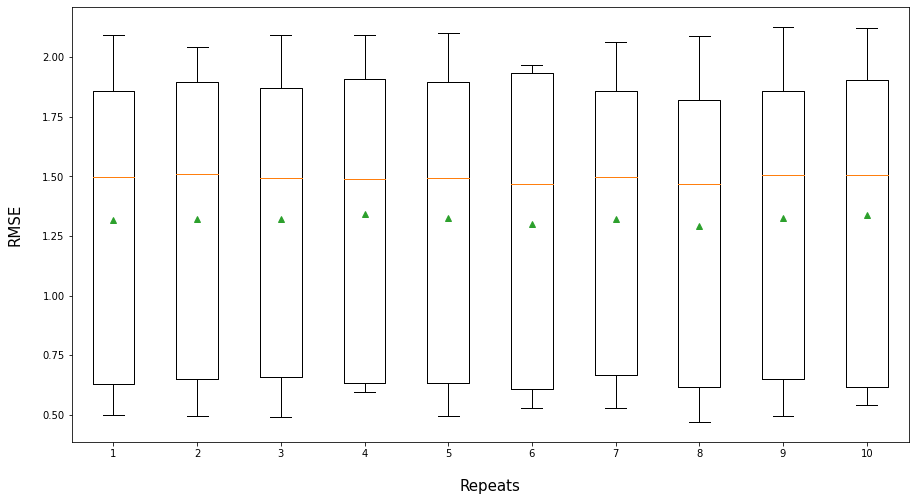

In [45]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 2</h4>
    
<b>Train 11 months and predicts one month every year</b>

In [46]:
train_period = 165 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 15 # 1 month
repeats = 10
results = results = make_repeated_time_series_k_fold(x, y, train_period, test_period, gridcv3, repeats)

RMSE: 1.863 (0.525)
RMSE: 1.876 (0.560)
RMSE: 1.864 (0.501)
RMSE: 1.819 (0.486)
RMSE: 1.882 (0.560)
RMSE: 1.813 (0.491)
RMSE: 1.829 (0.536)
RMSE: 1.886 (0.502)
RMSE: 1.860 (0.627)
RMSE: 1.835 (0.467)

RMSE: 1.853 (0.528)


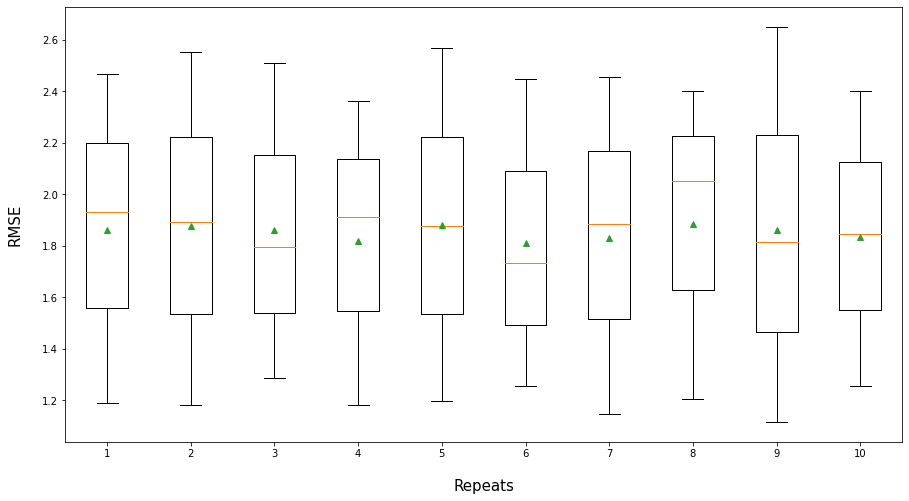

In [47]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 3</h4>
    
<b>Train 2 years and 10 months and predicts october and november of 2021</b>

In [48]:
train_period = 495 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 30 # 2 months
repeats = 10
results = results = make_repeated_time_series_k_fold(x, y, train_period, test_period, gridcv3, repeats)

RMSE: 0.854 (0.000)
RMSE: 0.853 (0.000)
RMSE: 0.821 (0.000)
RMSE: 0.813 (0.000)
RMSE: 0.806 (0.000)
RMSE: 0.735 (0.000)
RMSE: 0.702 (0.000)
RMSE: 0.762 (0.000)
RMSE: 0.735 (0.000)
RMSE: 0.787 (0.000)

RMSE: 0.787 (0.049)


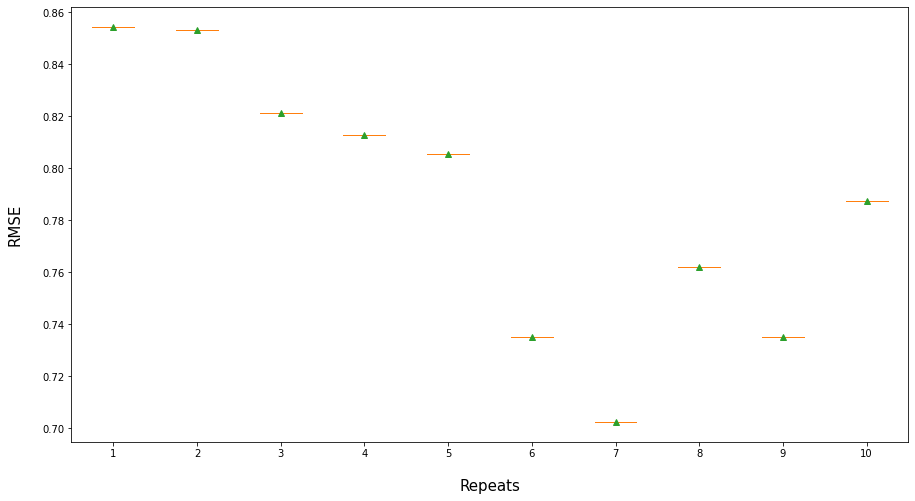

In [49]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

# Times Series Repeated KFold Cross validation - different Timesteps values

Here we will make a Times Series KFold Cross validation with all 3 datasets. Here we are using the Blocking Time Series Split method. And with timeseries Split method. We also do it with different number of timesteps

# Configs

<h3>Model</h3>
   
    LSTM Cells: 64
    LSTM Layers: 1
    Optimization Algorithm: Adam  
        Learning Rate: 1e-2
    Epochs: 100
    Batch size: 32


    
    
<h3>Timesteps: </h3>

    TIMESTEPS: [1, 3, 5, 7, 10, 15, 20]

<h3>Repeats: 10</h3>

In [50]:
def make_timesteps_repeated_time_series_k_fold(df,
                                               train_period,
                                               test_period,
                                               params=None,
                                               grid=None,
                                               repeats=10,
                                               timesteps_list=[3],
                                               show_results=True):
    results = {}
    
    for timesteps in timesteps_list:
        x, y = split_sequences(df.values, timesteps)
        scores = make_repeated_time_series_k_fold(x, y, train_period, test_period, grid, repeats, False, False, params)
        results[timesteps] = scores
        if show_results:
            print('TIMESTEPS: %d RMSE: %.3f (%.3f)' % (timesteps, np.mean(scores), np.std(scores)))
    return results

In [51]:
params = {}
params['activation'] = 'tanh'
params['dropout_rate'] = 0.0
params['n_units'] = 64
params['n_layers'] = 1
params['learning_rate'] = 1e-2
params['batch_size'] = 32
params['epochs'] = 100

timesteps_list = [1, 3, 5, 7, 10, 15, 20]

repeats = 10

<h3> Time Series Repeated KFold Cross Validation with vary timesteps - df_no_r3d_r7d</h3>

<b>Dataset: df_no_r3d_r7d:</b> In this dataset the R3D and R7D variables are not considered.

In [52]:
df = df_no_r3d_r7d.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)

<h4>Experiment 1</h4>
    
<b>Train 6 months and predicts one month every year</b>

In [53]:
train_period = 90 # 6 months of data since the data is spaced every 2 days
test_period = 15 # 1 month

<b>Baseline model</b>

In [54]:
results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, params, None, repeats, timesteps_list)

TIMESTEPS: 1 RMSE: 9.465 (5.366)
TIMESTEPS: 3 RMSE: 1.692 (0.774)
TIMESTEPS: 5 RMSE: 3.190 (5.740)
TIMESTEPS: 7 RMSE: 3.333 (7.360)
TIMESTEPS: 10 RMSE: 2.720 (5.792)
TIMESTEPS: 15 RMSE: 2.111 (2.035)
TIMESTEPS: 20 RMSE: 2.588 (4.861)


<h4>Experiment 2</h4>
    
<b>Train 11 months and predicts one month every year</b>

In [55]:
train_period = 165 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 15 # 1 month

<b>Baseline model</b>

In [56]:
results = results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, params, None, repeats, timesteps_list)


TIMESTEPS: 1 RMSE: 10.689 (2.424)
TIMESTEPS: 3 RMSE: 2.091 (1.327)
TIMESTEPS: 5 RMSE: 4.203 (7.335)
TIMESTEPS: 7 RMSE: 2.537 (3.946)
TIMESTEPS: 10 RMSE: 2.499 (4.774)
TIMESTEPS: 15 RMSE: 2.194 (3.473)
TIMESTEPS: 20 RMSE: 1.355 (0.706)


<h4>Experiment 3</h4>
    
<b>Train 2 years and 10 months and predicts october and november of 2021</b>

In [57]:
train_period = 495 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 30 # 2 months

<b>Baseline model</b>

In [58]:
results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, params, None, repeats, timesteps_list)

TIMESTEPS: 1 RMSE: 5.008 (0.883)
TIMESTEPS: 3 RMSE: 1.440 (0.301)
TIMESTEPS: 5 RMSE: 1.574 (0.307)
TIMESTEPS: 7 RMSE: 1.178 (0.233)
TIMESTEPS: 10 RMSE: 1.292 (0.442)
TIMESTEPS: 15 RMSE: 1.101 (0.480)
TIMESTEPS: 20 RMSE: 1.229 (0.431)


<h3> Time Series Repeated KFold Cross Validation - df_r3d_only</h3>

<b>Dataset: df_r3d_only:</b> In this dataset only R3D variable is considered.

In [63]:
df = df_r3d_only.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)

<h4>Experiment 1</h4>
    
<b>Train 6 months and predicts one month every year</b>

In [64]:
train_period = 90 # 6 months of data since the data is spaced every 2 days
test_period = 15 # 1 month

<b>Baseline model</b>

In [65]:
results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, params, None, repeats, timesteps_list)

TIMESTEPS: 1 RMSE: 9.679 (5.100)
TIMESTEPS: 3 RMSE: 1.882 (1.417)
TIMESTEPS: 5 RMSE: 2.978 (5.510)
TIMESTEPS: 7 RMSE: 1.847 (0.747)
TIMESTEPS: 10 RMSE: 1.862 (0.739)
TIMESTEPS: 15 RMSE: 1.846 (0.606)
TIMESTEPS: 20 RMSE: 2.330 (3.180)


<h4>Experiment 2</h4>
    
<b>Train 11 months and predicts one month every year</b>

In [66]:
train_period = 165 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 15 # 1 month

<b>Baseline model</b>

In [67]:
results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, params, None, repeats, timesteps_list)

TIMESTEPS: 1 RMSE: 10.570 (1.987)
TIMESTEPS: 3 RMSE: 1.998 (2.139)
TIMESTEPS: 5 RMSE: 2.046 (1.826)
TIMESTEPS: 7 RMSE: 2.823 (4.789)
TIMESTEPS: 10 RMSE: 3.231 (7.941)
TIMESTEPS: 15 RMSE: 1.265 (0.726)
TIMESTEPS: 20 RMSE: 1.294 (0.702)


<h4>Experiment 3</h4>
    
<b>Train 2 years and 10 months and predicts october and november of 2021</b>

In [68]:
train_period = 495 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 30 # 2 months

<b>Baseline model</b>

In [69]:
results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, params, None, repeats, timesteps_list)

TIMESTEPS: 1 RMSE: 5.068 (1.127)
TIMESTEPS: 3 RMSE: 1.609 (0.243)
TIMESTEPS: 5 RMSE: 1.599 (0.361)
TIMESTEPS: 7 RMSE: 1.175 (0.496)
TIMESTEPS: 10 RMSE: 0.885 (0.236)
TIMESTEPS: 15 RMSE: 1.220 (0.465)
TIMESTEPS: 20 RMSE: 1.058 (0.339)


<h3> Time Series Repeated KFold Cross Validation - df_r3d_and_r7d</h3>

<b>Dataset: df_r3d_and_r7d:</b> In this dataset both R3D and R7D variables are considered.

In [70]:
df = df_r3d_and_r7d.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)

<h4>Experiment 1</h4>
    
<b>Train 6 months and predicts one month every year</b>

In [71]:
train_period = 90 # 6 months of data since the data is spaced every 2 days
test_period = 15 # 1 month

<b>Baseline model</b>

In [72]:
results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, params, None, repeats, timesteps_list)

TIMESTEPS: 1 RMSE: 9.603 (5.170)
TIMESTEPS: 3 RMSE: 2.110 (1.483)
TIMESTEPS: 5 RMSE: 3.209 (7.086)
TIMESTEPS: 7 RMSE: 3.127 (5.166)
TIMESTEPS: 10 RMSE: 2.511 (4.244)
TIMESTEPS: 15 RMSE: 1.838 (0.618)
TIMESTEPS: 20 RMSE: 1.888 (0.605)


<h4>Experiment 2</h4>
    
<b>Train 11 months and predicts one month every year</b>

In [73]:
train_period = 165 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 15 # 1 month

<b>Baseline model</b>

In [74]:
results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, params, None, repeats, timesteps_list)

TIMESTEPS: 1 RMSE: 9.743 (2.084)
TIMESTEPS: 3 RMSE: 2.067 (1.476)
TIMESTEPS: 5 RMSE: 2.128 (2.197)
TIMESTEPS: 7 RMSE: 2.028 (2.183)
TIMESTEPS: 10 RMSE: 2.952 (6.385)
TIMESTEPS: 15 RMSE: 3.325 (6.370)
TIMESTEPS: 20 RMSE: 1.409 (0.842)


<h4>Experiment 3</h4>
    
<b>Train 2 years and 10 months and predicts october and november of 2021</b>

In [75]:
train_period = 495 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 30 # 2 months

<b>Baseline model</b>

In [76]:
results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, params, None, repeats, timesteps_list)

TIMESTEPS: 1 RMSE: 4.650 (0.598)
TIMESTEPS: 3 RMSE: 1.123 (0.153)
TIMESTEPS: 5 RMSE: 1.567 (0.397)
TIMESTEPS: 7 RMSE: 4.225 (8.612)
TIMESTEPS: 10 RMSE: 1.064 (0.354)
TIMESTEPS: 15 RMSE: 1.068 (0.363)
TIMESTEPS: 20 RMSE: 0.751 (0.265)
